<a href="https://colab.research.google.com/github/abhi99-ut/aih/blob/feature%2Fllm/LLM_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install openai pandas rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=bf0e458b7ee2a8d3fbcc68d538275f9f655246f4136ba856fe947f21362f9729
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import openai
import pandas as pd
from rouge_score import rouge_scorer
from matplotlib import pyplot as plt
from rouge_score import rouge_scorer


In [ ]:
# Load dataset
df = pd.read_json("hf://datasets/AGBonnet/augmented-clinical-notes/augmented_notes_30K.jsonl", lines=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df.shape

(30000, 5)

In [ ]:
df_sample = df.head(30)

In [ ]:
df_sample

,note,conversation,idx,summary,full_note
0,"A a sixteen year-old girl, presented to our Ou...","Doctor: Good morning, what brings you to the O...",155216,"{\n""visit motivation"": ""Discomfort in the neck...","A a sixteen year-old girl, presented to our Ou..."
1,This is the case of a 56-year-old man that was...,"Doctor: Hi, how are you feeling today?\nPatien...",77465,"{\n""visit motivation"": ""Complaints of a dull p...",This is the case of a 56-year-old man that was...
2,A 36-year old female patient visited our hospi...,"Doctor: Hello, what brings you to the hospital...",133948,"{\n""visit motivation"": ""Pain and restricted ra...",A 36-year old female patient visited our hospi...
3,A 49-year-old male presented with a complaint ...,"Doctor: Good morning, Mr. [Patient's Name]. I'...",80176,"{\n""visit motivation"": ""Pain in the left proxi...",A 49-year-old male presented with a complaint ...
4,A 47-year-old male patient was referred to the...,"Doctor: Good morning, how are you feeling toda...",72232,"{\n""visit motivation"": ""Recurrent attacks of p...",A 47-year-old male patient was referred to the...
5,A 24-year-old Yemeni female presented to the e...,"Doctor: Good morning, how are you feeling toda...",31864,"{\n""visit motivation"": ""Inability to walk and ...",A 24-year-old Yemeni female presented to the e...
6,We report a 24-day-old female baby who present...,"Doctor: Hi there, I am Dr. Smith. How can I he...",26809,"{\n""visit motivation"": ""Presented with dyspnea...",We report a 24-day-old female baby who present...
7,A 16 years old female patient presented to us ...,"Doctor: Good morning, what brings you here tod...",149866,"{\n""visit motivation"": ""Inability to walk on b...",A 16 years old female patient presented to us ...
8,We present a case of a seventy-three-year-old ...,"Doctor: Good morning, sir. How can I help you ...",87064,"{\n""visit motivation"": ""Concerned with having ...",We present a case of a seventy-three-year-old ...
9,A 23-year-old female patient was admitted to a...,"Doctor: Hi, how are you feeling today?\nPatien...",123006,"{\n""visit motivation"": ""esthetic problem cause...",A 23-year-old female patient was admitted to a...


In [ ]:
def basic_prompt(note, audience="professional"):
    prompt = f"""
    Clinical Note: {note}
    Audience: {'Healthcare Professional' if audience == 'professional' else 'Patient'}
    Task: Summarize the clinical note in a concise and clear way tailored to the given audience.
    """
    return prompt


In [ ]:
def few_shot_prompt(note, audience="professional"):
    examples = """
    Clinical Note: Patient has mild fever and cough. Advised rest and hydration.
    Professional Summary: Mild respiratory infection diagnosed. Advised symptomatic treatment with rest and hydration.

    Clinical Note: Patient reports severe headache and dizziness. Recommended CT scan to rule out underlying issues.
    Professional Summary: Neurological symptoms observed. Advised imaging for further evaluation.
    """
    prompt = f"""
    {examples}
    Clinical Note: {note}
    {'Professional Summary:' if audience == 'professional' else 'Patient-Friendly Summary:'}
    """
    return prompt


In [ ]:
def chain_of_thought_prompt(note):
    prompt = f"""
    Clinical Note: {note}
    Step-by-step reasoning:
    1. Identify symptoms and relevant medical history.
    2. Correlate symptoms with possible diagnoses.
    3. Propose a concise treatment plan.
    Summary:
    """
    return prompt


In [ ]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def generate_summary_with_prompt(prompt):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a clinical summarization assistant."},
                  {"role": "user", "content": prompt}],
        max_tokens=200
    )
    return response.choices[0].message.content


In [ ]:
results = []

for _, row in df_sample.iterrows():
    note = row["note"]

    # Generate summaries using different prompts
    basic_summary = generate_summary_with_prompt(basic_prompt(note, "professional"))
    few_shot_summary = generate_summary_with_prompt(few_shot_prompt(note, "professional"))
    chain_of_thought_summary = generate_summary_with_prompt(chain_of_thought_prompt(note))

    # Append results
    results.append({
        "note": note,
        "basic_summary": basic_summary,
        "few_shot_summary": few_shot_summary,
        "chain_of_thought_summary": chain_of_thought_summary
    })

# Create DataFrame for results
results_df = pd.DataFrame(results)
results_df.to_csv("summarization_results.csv", index=False)


In [ ]:
results_df

,note,basic_summary,few_shot_summary,chain_of_thought_summary
0,"A a sixteen year-old girl, presented to our Ou...",A sixteen-year-old girl presented with neck an...,"Patient, a sixteen year-old girl with bipolar ...",Summary:\nA sixteen-year-old girl presented wi...
1,This is the case of a 56-year-old man that was...,Summary:\nA 56-year-old man presented with rig...,56-year-old male presented with chronic right ...,Summary:\nA 56-year-old man presented with a d...
2,A 36-year old female patient visited our hospi...,Summary:\nA 36-year-old female patient present...,Patient is a 36-year-old female presenting wit...,Symptoms and Medical History:\n- 36-year-old f...
3,A 49-year-old male presented with a complaint ...,Summary:\nA 49-year-old male with a history of...,49-year-old male with a history of left elbow ...,Summary:\nA 49-year-old male with a history of...
4,A 47-year-old male patient was referred to the...,Summary:\nA 47-year-old male patient presented...,Rheumatology case summary:\n- 47-year-old male...,Summary:\nA 47-year-old male patient with recu...
5,A 24-year-old Yemeni female presented to the e...,Summary:\n- 24-year-old Yemeni female with a l...,24-year-old Yemeni female presented with a lon...,Symptoms and Medical History:\n- 24-year-old Y...
6,We report a 24-day-old female baby who present...,A 24-day-old female baby presented with dyspne...,Pediatric case of left-sided diaphragmatic her...,The patient is a 24-day-old female baby who pr...
7,A 16 years old female patient presented to us ...,Summary:\nA 16-year-old female presented with ...,16-year-old female with a history of bilateral...,Symptoms and relevant medical history: A 16-ye...
8,We present a case of a seventy-three-year-old ...,Summary:\nA seventy-three-year-old Saudi man w...,Patient: Seventy-three-year-old Saudi man with...,Summary:\nA seventy-three-year-old Saudi man h...
9,A 23-year-old female patient was admitted to a...,A 23-year-old female patient with scalp swelli...,Patient with a history of scalp swelling under...,Summary:\nA 23-year-old female patient present...


In [ ]:
results_df['note'][0]

'A a sixteen year-old girl, presented to our Outpatient department with the complaints of discomfort in the neck and lower back as well as restriction of body movements. She was not able to maintain an erect posture and would tend to fall on either side while standing up from a sitting position. She would keep her head turned to the right and upwards due to the sustained contraction of the neck muscles. There was a sideways bending of the back in the lumbar region. To counter the abnormal positioning of the back and neck, she would keep her limbs in a specific position to allow her body weight to be supported. Due to the restrictions with the body movements at the neck and in the lumbar region, she would require assistance in standing and walking. She would require her parents to help her with daily chores, including all activities of self-care.\nShe had been experiencing these difficulties for the past four months since when she was introduced to olanzapine tablets for the control of 

In [ ]:
from IPython.display import display, HTML

def wrap_output(text):
    return display(HTML('<div style="white-space: pre-wrap;">' + text + '</div>'))


In [ ]:
wrap_output(results_df['basic_summary'][0])

In [ ]:
wrap_output(results_df['few_shot_summary'][0])

In [ ]:
wrap_output(results_df['chain_of_thought_summary'][0])

In [ ]:

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Reference summary for evaluation
reference_summary = "Patient diagnosed with mild respiratory infection. Symptomatic treatment recommended."

# Evaluate summaries
metrics = []
for prompt_type, summary in zip(
    ["Basic", "Few-Shot", "Chain-of-Thought"],
    [results_df.iloc[0]['basic_summary'],
     results_df.iloc[0]['few_shot_summary'],
     results_df.iloc[0]['chain_of_thought_summary']]
):
    scores = scorer.score(reference_summary, summary)
    metrics.append({
        "Prompt Type": prompt_type,
        "ROUGE-1 Precision": scores['rouge1'].precision,
        "ROUGE-1 Recall": scores['rouge1'].recall,
        "ROUGE-1 F1": scores['rouge1'].fmeasure,
        "ROUGE-2 Precision": scores['rouge2'].precision,
        "ROUGE-2 Recall": scores['rouge2'].recall,
        "ROUGE-2 F1": scores['rouge2'].fmeasure,
        "ROUGE-L Precision": scores['rougeL'].precision,
        "ROUGE-L Recall": scores['rougeL'].recall,
        "ROUGE-L F1": scores['rougeL'].fmeasure
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


        Prompt Type  ROUGE-1 Precision  ROUGE-1 Recall  ROUGE-1 F1  \
0             Basic           0.014493        0.111111    0.025641   
1          Few-Shot           0.057143        0.444444    0.101266   
2  Chain-of-Thought           0.022222        0.333333    0.041667   

   ROUGE-2 Precision  ROUGE-2 Recall  ROUGE-2 F1  ROUGE-L Precision  \
0                0.0             0.0         0.0           0.014493   
1                0.0             0.0         0.0           0.057143   
2                0.0             0.0         0.0           0.014815   

   ROUGE-L Recall  ROUGE-L F1  
0        0.111111    0.025641  
1        0.444444    0.101266  
2        0.222222    0.027778  


In [ ]:
metrics_df

,Prompt Type,ROUGE-1 Precision,ROUGE-1 Recall,ROUGE-1 F1,ROUGE-2 Precision,ROUGE-2 Recall,ROUGE-2 F1,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1
0,Basic,0.014493,0.111111,0.025641,0.0,0.0,0.0,0.014493,0.111111,0.025641
1,Few-Shot,0.057143,0.444444,0.101266,0.0,0.0,0.0,0.057143,0.444444,0.101266
2,Chain-of-Thought,0.022222,0.333333,0.041667,0.0,0.0,0.0,0.014815,0.222222,0.027778


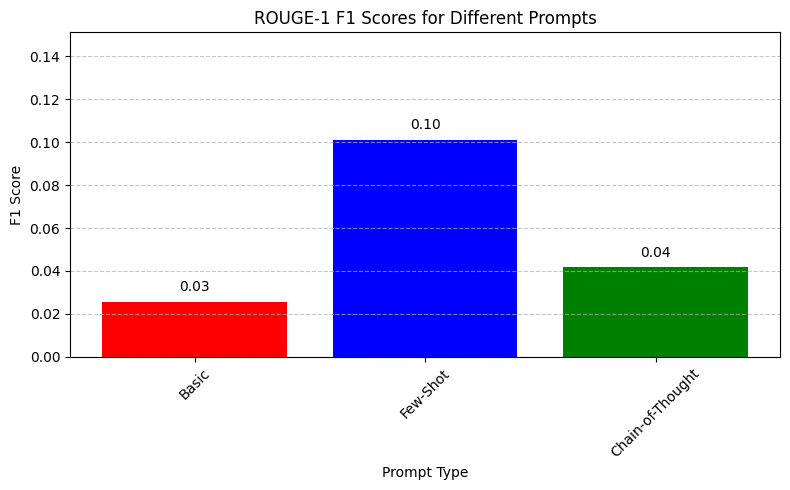

In [ ]:

# Melt DataFrame for plotting
metrics_melted = metrics_df.melt(id_vars=["Prompt Type"], var_name="Metric", value_name="Score")

# Plot ROUGE-1 F1 scores
rouge1_f1 = metrics_melted[metrics_melted["Metric"] == "ROUGE-1 F1"]

plt.figure(figsize=(8, 5))
plt.bar(rouge1_f1["Prompt Type"], rouge1_f1["Score"], color=["red", "blue", "green"])
plt.title("ROUGE-1 F1 Scores for Different Prompts")
plt.ylabel("F1 Score")
plt.xlabel("Prompt Type")
plt.ylim(0, max(rouge1_f1["Score"]) + 0.05)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate bar heights
for index, value in enumerate(rouge1_f1["Score"]):
    plt.text(index, value + 0.005, f"{value:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()
